# Paper materials

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
import seaborn as sns
from sklearn.metrics import mean_squared_error

from uncertainty import ensemble_uncertainties_regression
from plot_utils import fast_plot, fast_hist, fast_legend, feature_snapshot, fast_scatter

In [2]:
def get_predictions(features_df, model):
    '''
    Calculates predictions on df features for specified model
    
    Return: array [num_samples x 2],
        where
            num_samples = number of rows in features_df
            2 = [mean, variance]
    
    '''
    return model.predict(features_df)


def get_all_predictions_mixed(features_df, models_list, features_df_2, models_list_2):
    '''
    Return: array [ensemble_size x num_samples x 2],
        where
            ensemble_size = number of models in models_list
            num_samples = number of rows in features_df
            2 = [mean, variance]
    '''
    all_preds = []
    for model in models_list:
        preds = np.asarray(get_predictions(features_df, model))
        all_preds.append(preds)
        
    for model in models_list_2:
        preds = np.asarray(get_predictions(features_df_2, model))
        all_preds.append(preds)
    return np.stack(all_preds, axis=0)

## Загрузка данных

In [3]:
%%time

with open('../data/processed/train.pcl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test.pcl', 'rb') as f:
    test = pickle.load(f)
    
train = train.sort_values(['fact_temperature', 'climate', 'fact_cwsm_class', 
                           'fact_latitude', 'fact_longitude', 'fact_time'])

train.index = [x for x in range(train.shape[0])]
test.index = [x for x in range(test.shape[0])]

print('Train:', train.shape)
print('Test:', test.shape, '\n')

Train: (3129592, 131)
Test: (1137731, 125) 

Wall time: 4.66 s


## Feature sets

In [4]:
target = 'fact_temperature'
features = list(train.columns[6:]) 
features2 = ['x1', 'wrf_t2', 'x2', 'gfs_temperature_sea', 'cmc_0_0_0_2_interpolated',
             'gfs_temperature_sea_interpolated', 'wrf_t2_interpolated',
             'cmc_0_0_0_1000', 'topography_bathymetry', 'cmc_0_0_0_2',
             'sun_elevation', 'wrf_t2_next', 'gfs_pressure', 'gfs_soil_temperature',
             'climate_pressure', 'cmc_0_3_0_0_next', 'wrf_rh2', 'cmc_0_3_0_0',
             'climate_temperature', 'cmc_0_0_0_2_grad', 'gfs_temperature_10000',
             'gfs_humidity', 'cmc_0_1_0_0', 'cmc_0_0_7_925', 'gfs_wind_speed',
             'gfs_temperature_5000', 'gfs_a_vorticity', 'gfs_temperature_97500',
             'gfs_temperature_7000', 'wrf_psfc', 'wrf_wind_u',
             'gfs_total_clouds_cover_low_next', 'cmc_0_2_2_500', 'gfs_r_velocity',
             'gfs_temperature_sea_grad', 'cmc_0_0_0_850', 'cmc_timedelta_s',
             'wrf_wind_v', 'gfs_precipitable_water', 'cmc_0_3_5_850', 'cmc_0_2_3_10',
             'cmc_0_0_7_2', 'cmc_0_0_0_925', 'cmc_0_0_7_850', 'cmc_0_3_5_925',
             'gfs_temperature_25000', 'cmc_0_3_1_0', 'gfs_temperature_95000',
             'wrf_t2_grad', 'gfs_2m_dewpoint_next', 'cmc_0_2_2_700', 'cmc_0_2_3_925',
             'gfs_cloudness', 'gfs_temperature_20000', 'cmc_0_2_3_500',
             'gfs_temperature_80000', 'gfs_temperature_15000', 'cmc_0_0_6_2',
             'gfs_total_clouds_cover_low', 'cmc_0_2_2_1000']
features

['topography_bathymetry',
 'sun_elevation',
 'climate_temperature',
 'climate_pressure',
 'cmc_0_0_0_1000',
 'cmc_0_0_0_2_grad',
 'cmc_0_0_0_2_interpolated',
 'cmc_0_0_0_2_next',
 'cmc_0_0_0_2',
 'cmc_0_0_0_500',
 'cmc_0_0_0_700',
 'cmc_0_0_0_850',
 'cmc_0_0_0_925',
 'cmc_0_0_6_2',
 'cmc_0_0_7_1000',
 'cmc_0_0_7_2',
 'cmc_0_0_7_500',
 'cmc_0_0_7_700',
 'cmc_0_0_7_850',
 'cmc_0_0_7_925',
 'cmc_0_1_0_0',
 'cmc_0_1_11_0',
 'cmc_0_1_65_0',
 'cmc_0_1_66_0',
 'cmc_0_1_67_0',
 'cmc_0_1_68_0',
 'cmc_0_1_7_0',
 'cmc_0_2_2_10',
 'cmc_0_2_2_1000',
 'cmc_0_2_2_500',
 'cmc_0_2_2_700',
 'cmc_0_2_2_850',
 'cmc_0_2_2_925',
 'cmc_0_2_3_10',
 'cmc_0_2_3_1000',
 'cmc_0_2_3_500',
 'cmc_0_2_3_700',
 'cmc_0_2_3_850',
 'cmc_0_2_3_925',
 'cmc_0_3_0_0',
 'cmc_0_3_0_0_next',
 'cmc_0_3_1_0',
 'cmc_0_3_5_1000',
 'cmc_0_3_5_500',
 'cmc_0_3_5_700',
 'cmc_0_3_5_850',
 'cmc_0_3_5_925',
 'cmc_0_6_1_0',
 'cmc_available',
 'cmc_horizon_h',
 'cmc_precipitations',
 'cmc_timedelta_s',
 'gfs_2m_dewpoint',
 'gfs_a_vorticity'

## Load models

In [5]:
%%time
# Uncertainty estimation models

# Orange uncertainty models
uncert_orange = []

n_models = 200
folds = 25
calculated_models = 50

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/orange_box_{model_number}_{folds}_{n_models}.cbm')
    uncert_orange.append(model)

    
# Bronze uncertainty models 
uncert_bronze = []

n_models = 200
folds = 25
calculated_models = 27

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/bronze_box_{model_number}_{folds}_{n_models}.cbm')
    uncert_bronze.append(model)
    
print('Orange models:', len(uncert_orange))
print('Bronze models:', len(uncert_bronze))

Orange models: 50
Bronze models: 27
Wall time: 811 ms


In [6]:
%%time
# Temperature prediction models

# Purple + Aqua rmse models
rmse_purple_aqua = []

## Purple
n_models = 50
folds = 25
calculated_models = 32

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/purple_box_{model_number}_{folds}_{n_models}.cbm')
    rmse_purple_aqua.append(model)
    
## Aqua 
n_models = 20
folds = 20
calculated_models = 5

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/aqua_box_{model_number}_{folds}_{n_models}.cbm')
    rmse_purple_aqua.append(model)


# Silver rmse models
rmse_silver = []

n_models = 50
folds = 30
calculated_models = 12

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/silver_box_{model_number}_{folds}_{n_models}.cbm')
    rmse_silver.append(model)

    
print('Purple + Aqua models:', len(rmse_purple_aqua))
print('Silver models:', len(rmse_silver))

Purple + Aqua models: 37
Silver models: 12
Wall time: 6.69 s


# Local validation

In [7]:
def calculate_score(true, pred, uncertainties):
    df = pd.DataFrame(uncertainties.copy())
    df.columns = ['uncertainties']
    
    df['error'] = ((true.values - pred) ** 2)
    df = df.sort_values('uncertainties')
    df.index = range(df.shape[0])    
    
    score = df['error'].cumsum().mean() / df.shape[0]    
    return df, score

In [8]:
with open('../data/processed/dev_in.pcl', 'rb') as f:
    dev_in = pickle.load(f)
    
with open('../data/processed/dev_out.pcl', 'rb') as f:
    dev_out = pickle.load(f)

dev = pd.concat([dev_in, dev_out])
dev.index = range(dev.shape[0])

In [9]:
%%time
uncert_preds_dev = get_all_predictions_mixed(dev[features], uncert_orange, dev[features2], uncert_bronze)
all_uncertainty_dev = ensemble_uncertainties_regression(uncert_preds_dev)
uncertainties_dev = all_uncertainty_dev['tvar']

Wall time: 9.26 s


In [10]:
%%time
all_preds_dev = get_all_predictions_mixed(dev[features], rmse_purple_aqua, dev[features2], rmse_silver)
avg_preds_dev = np.squeeze(np.mean(all_preds_dev, axis=0))
preds_std_dev = all_preds_dev.std(axis=0)

Wall time: 1min 3s


# Temperature prediction mixing models

In [11]:
def get_all_preds(features_df, models_list, features_df_2, models_list_2):
    '''
    Return: array [ensemble_size x num_samples x 2],
        where
            ensemble_size = number of models in models_list
            num_samples = number of rows in features_df
            2 = [mean, variance]
    '''
    all_preds = []        
    for model in models_list_2:
        preds = np.asarray(get_predictions(features_df_2, model))
        all_preds.append(preds)
        
    for model in models_list:
        preds = np.asarray(get_predictions(features_df, model))
        all_preds.append(preds)
        
    return all_preds

In [12]:
%%time
all_preds = get_all_preds(dev[features], rmse_purple_aqua, dev[features2], rmse_silver)

Wall time: 1min 2s


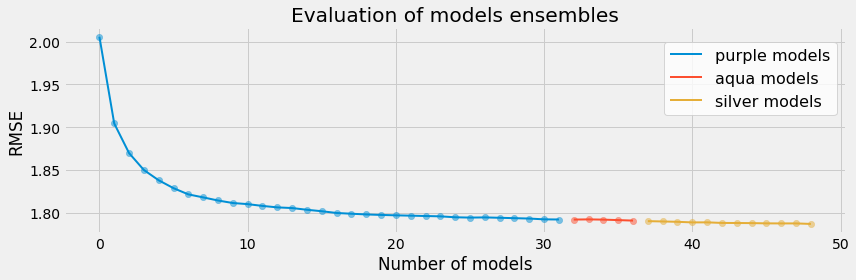

In [13]:
mix_results_revers = []

for n_models in range(len(all_preds)):
    preds = np.array(all_preds[::-1][:n_models + 1]).mean(axis=0)
    rmse = mean_squared_error(dev[target], preds) ** 0.5
    mix_results_revers.append(rmse)
    
df2 = pd.DataFrame(index=range(len(mix_results_revers)), data=mix_results_revers, columns=['RMSE'])

df2['model type'] = ['purple' for x in range(32)] + ['aqua' for x in range(5)] + ['silver' for x in range(12)]
df2['diff'] = df2['RMSE'].diff()


new_figure = True
for model_type in df2['model type'].unique():
    mask = df2['model type'] == model_type
    fast_plot(df2['RMSE'][mask], label=model_type + ' models', new_figure=new_figure, title='Evaluation of models ensembles')
    plt.ylabel('RMSE')
    plt.xlabel('Number of models')
    fast_legend(ncol=1, pos=(0.877, 0.97))
    new_figure = False
    
plt.tight_layout()
plt.savefig(dpi=300, fname='../report/temperature_models.png')

# Uncertainy prediction

In [14]:
std_score = calculate_score(dev[target], np.array(all_preds).mean(axis=0), np.array(all_preds).std(axis=0))[1]
print('Std score:', std_score)

Std score: 1.1016757784366669


In [15]:
uncertainty_score = calculate_score(dev[target], np.array(all_preds).mean(axis=0), uncertainties_dev)[1]
print('Uncertainty score:', uncertainty_score)

Uncertainty score: 1.0726089297757482


## Uncertainty Std mixing strategies

,std_rate,score,log_score,log_log_score
1252,1.252,1.045121,1.047612,1.054609


,std_rate,score,log_score,log_log_score
671,0.671,1.048367,1.042605,1.04404


,std_rate,score,log_score,log_log_score
443,0.443,1.052794,1.044359,1.041855


            std_rate       score
Original:               1.07260893
Unc - std: [[1.252      1.04512074]]
Log:       [[0.671     1.0426052]]
Log Log:   [[0.443      1.04185526]]
Wall time: 1min 24s


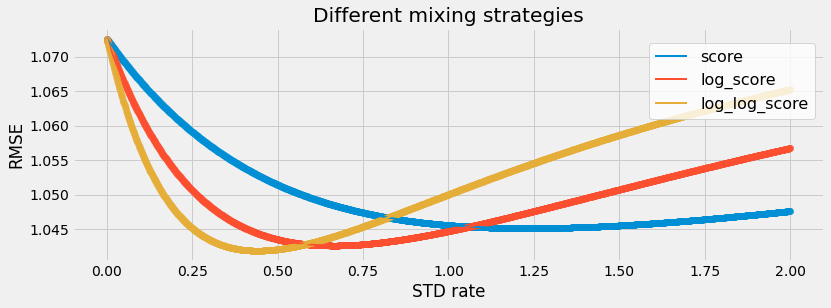

In [16]:
%%time
std_df = pd.DataFrame(np.linspace(0, 2, 2001), columns=['std_rate'])
std_df['score'] = np.NaN
std_df['log_score'] = np.NaN
std_df['log_log_score'] = np.NaN

for row in range(std_df.shape[0]):
    
    # Normalized uncertainties score - normalized std
    uncertainties2_dev = uncertainties_dev.copy()
    uncertainties2_dev = uncertainties2_dev/ np.median(uncertainties2_dev)
    uncertainties2_dev = uncertainties2_dev + preds_std_dev / np.median(preds_std_dev) * std_df['std_rate'].iloc[row]    
    
    df, score = calculate_score(dev[target], avg_preds_dev, uncertainties2_dev)
    std_df['score'].iloc[row] = score
    
    # Normalized Log1p uncertainties score - normalized std
    uncertainties3_dev = np.log1p(uncertainties_dev.copy())
    uncertainties3_dev /= np.median(uncertainties3_dev)
    uncertainties3_dev = uncertainties3_dev + preds_std_dev / np.median(preds_std_dev) * std_df['std_rate'].iloc[row]  

    df, score = calculate_score(dev[target], avg_preds_dev, uncertainties3_dev)
    std_df['log_score'].iloc[row] = score
    
    # Normalized Log1p Log1p uncertainties score - normalized std
    uncertainties4_dev = np.log1p(np.log1p(uncertainties_dev.copy()))
    uncertainties4_dev /= np.median(uncertainties4_dev)
    uncertainties4_dev = uncertainties4_dev + preds_std_dev / np.median(preds_std_dev) * std_df['std_rate'].iloc[row]  

    df, score = calculate_score(dev[target], avg_preds_dev, uncertainties4_dev)
    std_df['log_log_score'].iloc[row] = score
    
    
fast_plot(std_df.set_index('std_rate')['score'], title='Different mixing strategies')
fast_plot(std_df.set_index('std_rate')['log_score'], new_figure=False)
fast_plot(std_df.set_index('std_rate')['log_log_score'], new_figure=False)

plt.ylabel('RMSE')
plt.xlabel('STD rate')
fast_legend(ncol=1, pos=(0.877, 0.97))

display(std_df[std_df['score'] == std_df['score'].min()])
display(std_df[std_df['log_score'] == std_df['log_score'].min()])
display(std_df[std_df['log_log_score'] == std_df['log_log_score'].min()])


df, score = calculate_score(dev[target], avg_preds_dev, uncertainties_dev)
print('            std_rate       score')
print(f'Original:               {round(score, 8)}')
print('Unc - std:', std_df[std_df['score'] == std_df['score'].min()][['std_rate', 'score']].values)
print('Log:      ', std_df[std_df['log_score'] == std_df['log_score'].min()][['std_rate', 'log_score']].values)
print('Log Log:  ', std_df[std_df['log_log_score'] == std_df['log_log_score'].min()][['std_rate', 'log_log_score']].values)

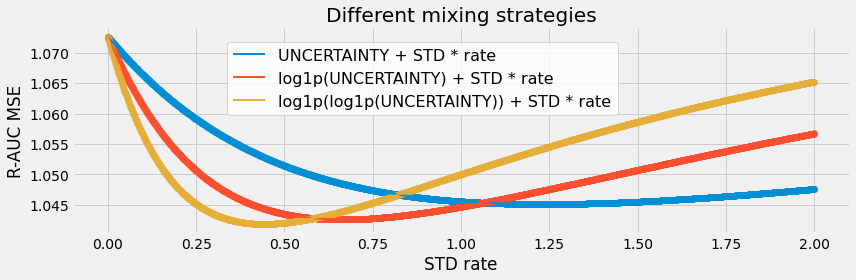

In [17]:
fast_plot(std_df.set_index('std_rate')['score'], title='Different mixing strategies', label='UNCERTAINTY + STD * rate')
fast_plot(std_df.set_index('std_rate')['log_score'], new_figure=False, label='log1p(UNCERTAINTY) + STD * rate')
fast_plot(std_df.set_index('std_rate')['log_log_score'], new_figure=False, label='log1p(log1p(UNCERTAINTY)) + STD * rate')

plt.ylabel('R-AUC MSE')
plt.xlabel('STD rate')
fast_legend(ncol=1, pos=(0.45, 0.97));

plt.tight_layout()
plt.savefig(dpi=300, fname='../report/uncert_models.png')

In [18]:
Mix_UNC_STD = (np.log1p(np.log1p(uncertainties_dev)) / np.median(np.log1p(np.log1p(uncertainties_dev))) + 
               0.443 * preds_std_dev / np.median(preds_std_dev))
uncertainty_std_score = calculate_score(dev[target], np.array(all_preds).mean(axis=0), Mix_UNC_STD)[1]
print('Uncertainty score:', uncertainty_std_score)

Uncertainty score: 1.041855256328544


## Distribution exploring

In [19]:
distribution_features = ['x1', 'wrf_t2', 'x2', 'gfs_temperature_sea', 'cmc_0_0_0_2_interpolated',
                         'gfs_temperature_sea_interpolated', 'wrf_t2_interpolated',
                         'cmc_0_0_0_1000', 'topography_bathymetry', 'cmc_0_0_0_2',
                         'sun_elevation', 'gfs_pressure', 'gfs_soil_temperature', 'climate_pressure',
                         'cmc_0_3_0_0_next', 'wrf_rh2', 'climate_temperature', 'cmc_0_0_0_2_grad',
                         'gfs_temperature_10000', 'gfs_humidity', 'cmc_0_1_0_0', 'cmc_0_0_7_925',
                         'gfs_wind_speed', 'wrf_psfc', 'wrf_wind_u',
                         'gfs_temperature_sea_grad', 'cmc_timedelta_s']

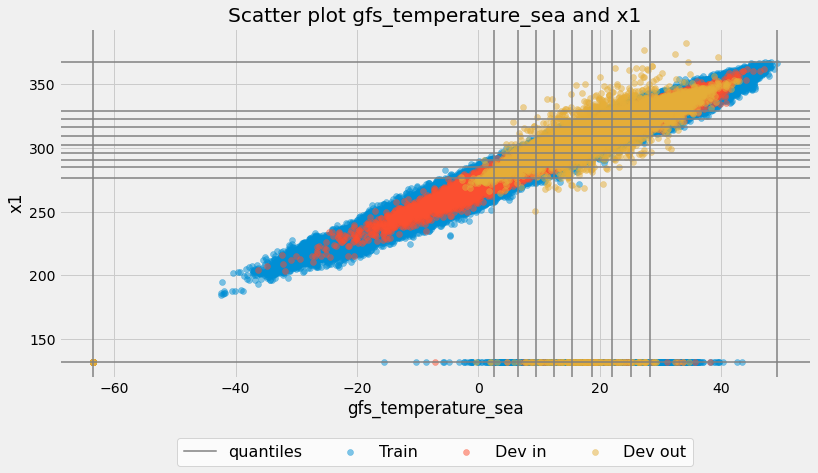

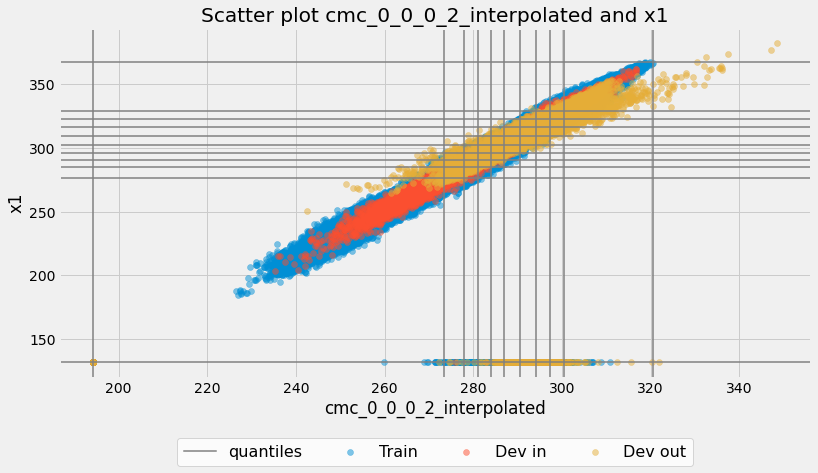

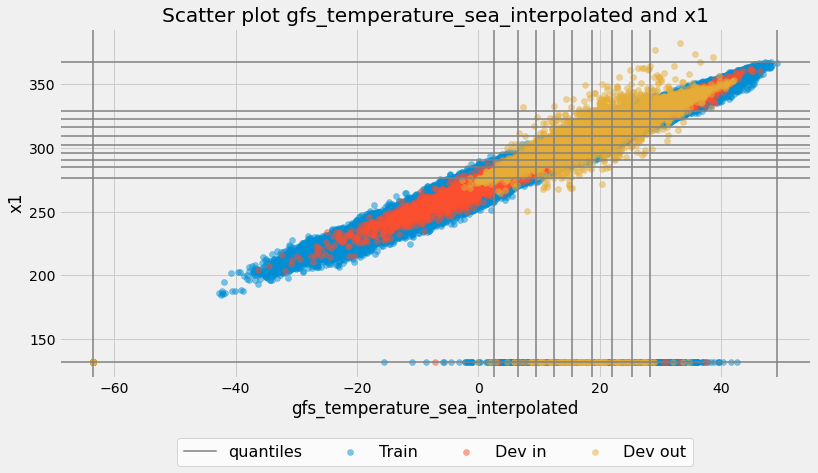

In [20]:
# Several scatter diagrams for selected features, quantiles for each feature are plotted in gray grid
# For each cell in the grid, the number of observations on the training sample will be counted
# Further, for each observation for all pairs of features, the sum of objects in the grids will be calculated

for feature in distribution_features[3:6]:
    title = f'Scatter plot {feature} and x1'
    
    fast_scatter(train[feature], train['x1'], figsize=(12, 6), label='Train', plot_legend=False, title=title)
    fast_scatter(dev_in[feature], dev_in['x1'], figsize=(12, 6), label='Dev in', new_figure=False)
    fast_scatter(dev_out[feature], dev_out['x1'], figsize=(12, 6), label='Dev out', new_figure=False)
    
    first_execution = True
    for q in np.linspace(0, 1, 11):
        if first_execution:
            plt.axvline(train[feature].quantile(q), color='grey', label='quantiles')
            first_execution = False
        else:
            plt.axvline(train[feature].quantile(q), color='grey')
        plt.axhline(train['x1'].quantile(q), color='grey')
    
    fast_legend(ncol=4)
    plt.show();

In [21]:
def distribution_count(train_data, test_data, feature1, feature2, bins=10):
    features = [feature1, feature2]
    print(features)
    qs = np.linspace(0, 1, bins + 1)

    train_data = train[features].copy()
    test_data = test_data[features].copy()
    test_data['counter'] = np.NaN

    train_masks_feature1 = []
    train_masks_feature2 = []
    test_masks_feature1 = []
    test_masks_feature2 = []


    for i in range(bins):
        feature1_min_value = train_data[feature1].quantile(qs[i])
        feature1_max_value = train_data[feature1].quantile(qs[i + 1])
        feature2_min_value = train_data[feature2].quantile(qs[i])
        feature2_max_value = train_data[feature2].quantile(qs[i + 1])
    
    
        # Train
        train_mask1 = ((train_data[feature1] >= feature1_min_value) & 
                       (train_data[feature1] <= feature1_max_value))
        train_mask2 = ((train_data[feature2] >= feature2_min_value) &
                       (train_data[feature2] <= feature2_max_value)) 
    
        train_masks_feature1.append(train_mask1)
        train_masks_feature2.append(train_mask2)
    
    
        # Test
        test_mask1 = ((test_data[feature1] >= feature1_min_value) & 
                      (test_data[feature1] <= feature1_max_value))
        test_mask2 = ((test_data[feature2] >= feature2_min_value) &
                      (test_data[feature2] <= feature2_max_value))
    
        test_masks_feature1.append(test_mask1)
        test_masks_feature2.append(test_mask2)
    
    
    
    df = pd.DataFrame(index = qs[1:], columns=qs[1:])
    for i in range(bins):
        for j in range(bins):
            count = (train_masks_feature1[i] * train_masks_feature2[j]).sum()
            df.loc[qs[i + 1], qs[j + 1]] = count
        
            test_mask = test_masks_feature1[i] * test_masks_feature2[j]
            idx = test_mask[test_mask].index
            test_data.loc[idx, 'counter'] = count
        
    test_data['counter'] = test_data['counter'].fillna(0)
    
    
    return df, test_data['counter'].copy()

['x2', 'cmc_0_0_0_2_interpolated']


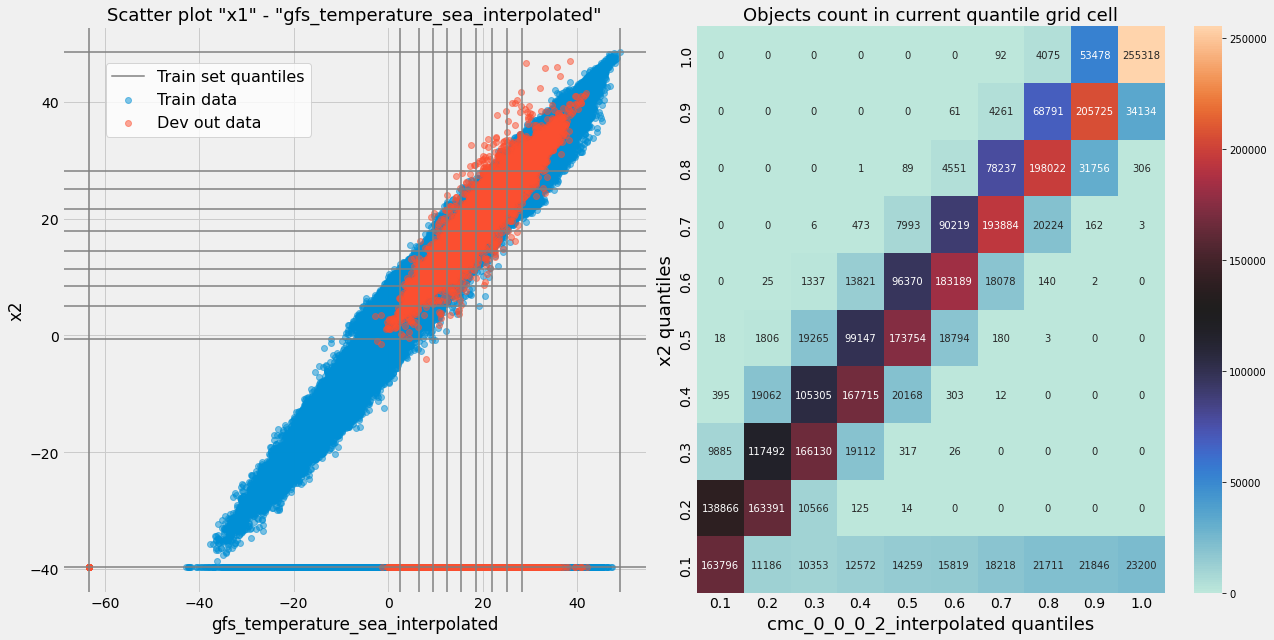

In [22]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(ncols=2, figsize=(18, 9))

title = f'Scatter plot "x1" - "{feature}"'

fast_scatter(train[feature], train['x2'], figsize=(12, 6), label='Train data', plot_legend=False, 
             title=title, ax=ax[0])
fast_scatter(dev_out[feature], dev_out['x2'], figsize=(12, 6), label='Dev out data', new_figure=False,
             ax=ax[0])
ax[0].set_title(title, fontsize=18)    
first_execution = True
for q in np.linspace(0, 1, 11):
    if first_execution:
        ax[0].axvline(train[feature].quantile(q), color='grey', label='Train set quantiles')
        first_execution = False
    else:
        ax[0].axvline(train[feature].quantile(q), color='grey')
    ax[0].axhline(train['x2'].quantile(q), color='grey')
    
fast_legend(ncol=1, ax=ax[0], pos=(0.25, 0.95))



feature1 = 'x2'
feature2 = 'cmc_0_0_0_2_interpolated'
    
df, counter = distribution_count(train, dev, feature1, feature2, bins=10)
df.columns = [np.round(x, 1) for x in df.columns]
df.index = [np.round(x, 1) for x in df.index]
df = df.sort_index(ascending=False)

sns.heatmap(df.astype(int), annot=True, fmt='d', ax=ax[1], cmap='icefire');
plt.title('Objects count in current quantile grid cell', fontsize=18)
plt.xlabel(feature2 + ' quantiles', fontsize=18)
plt.ylabel(feature1 + ' quantiles', fontsize=18)

plt.tight_layout()
plt.savefig(dpi=300, fname='../report/objects_count.png')

['x1', 'wrf_t2']
['x1', 'x2']
['x1', 'gfs_temperature_sea']
['x1', 'cmc_0_0_0_2_interpolated']
['x1', 'gfs_temperature_sea_interpolated']
['x1', 'wrf_t2_interpolated']
['x1', 'cmc_0_0_0_1000']
['x1', 'topography_bathymetry']
['x1', 'cmc_0_0_0_2']
['x1', 'sun_elevation']
['x1', 'gfs_pressure']
['x1', 'gfs_soil_temperature']
['x1', 'climate_pressure']
['x1', 'cmc_0_3_0_0_next']
['x1', 'wrf_rh2']
['x1', 'climate_temperature']
['x1', 'cmc_0_0_0_2_grad']
['x1', 'gfs_temperature_10000']
['x1', 'gfs_humidity']
['x1', 'cmc_0_1_0_0']
['x1', 'cmc_0_0_7_925']
['x1', 'gfs_wind_speed']
['x1', 'wrf_psfc']
['x1', 'wrf_wind_u']
['x1', 'gfs_temperature_sea_grad']
['x1', 'cmc_timedelta_s']


No handles with labels found to put in legend.


Wall time: 1min 32s


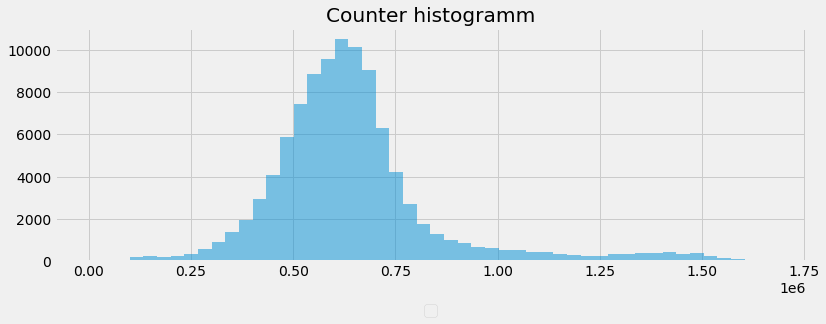

In [23]:
%%time
counter_list = []

for feature2 in distribution_features[1:]:
    feature1 = distribution_features[0]
    df, counter = distribution_count(train, dev, feature1, feature2, bins=20)
    counter_list.append(counter)
    
counter = pd.concat(counter_list, axis=1).sum(axis=1)
fast_hist(counter, bins=50, title='Counter histogramm')

## UncertaintyStd Counter mixing coefficient

In [24]:
STD = preds_std_dev
UNCERTAINTY = uncertainties_dev
Mix_UNC_STD = np.log1p(np.log1p(UNCERTAINTY)) / np.median(np.log1p(np.log1p(UNCERTAINTY))) + 0.443 * STD / np.median(STD)
COUNTER = -counter

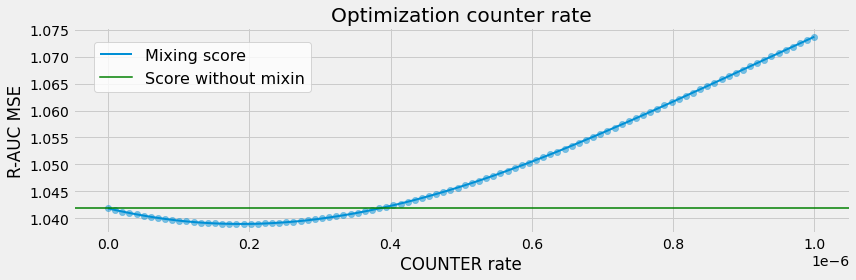

In [25]:
rate_df = pd.DataFrame(np.linspace(0.000001, 0, 100), columns=['distribution_rate'])
rate_df['score'] = np.NaN

for row in range(rate_df.shape[0]):
    rate = rate_df['distribution_rate'].iloc[row]
    df, score = calculate_score(dev[target], avg_preds_dev, Mix_UNC_STD + COUNTER * rate)
    rate_df.loc[row, 'score'] = score

fast_plot(rate_df.set_index('distribution_rate')['score'], title='Optimization counter rate', label='Mixing score')
plt.axhline(1.041855256328544, label='Score without mixin', color='green')
plt.ylabel('R-AUC MSE')
plt.xlabel('COUNTER rate')
fast_legend(ncol=1, pos=(0.167, 0.97));

mask = rate_df['score'] == rate_df['score'].min()
rate_df[mask]

plt.tight_layout()
plt.savefig(dpi=300, fname='../report/count_optimization.png')

In [26]:
optimal_rate = rate_df[rate_df['score'] == rate_df['score'].min()]['distribution_rate'].values[0]
print(f'Optimal rate: {optimal_rate}')

Optimal rate: 1.9191919191919197e-07


In [27]:
FINAL_UNC = Mix_UNC_STD + COUNTER * optimal_rate

final_uncertainty_score = calculate_score(dev[target], np.array(all_preds).mean(axis=0), FINAL_UNC)[1]
print('UncertaintyStdCounter score:', final_uncertainty_score)

UncertaintyStdCounter score: 1.0389663537680034


# Sumarizing results

In [28]:
index = ['STD', 'UNCERTAINTY', 'Mix_UNC_STD', 'COUNTER', 'FINAL_UNC']
values = [calculate_score(dev[target], np.array(all_preds).mean(axis=0), STD)[1], 
          calculate_score(dev[target], np.array(all_preds).mean(axis=0), UNCERTAINTY)[1],
          calculate_score(dev[target], np.array(all_preds).mean(axis=0), Mix_UNC_STD)[1],
          calculate_score(dev[target], np.array(all_preds).mean(axis=0), COUNTER)[1],
          calculate_score(dev[target], np.array(all_preds).mean(axis=0), FINAL_UNC)[1] 
         ]

df = pd.DataFrame(index=index, data=values, columns=['Score R-AUC MSE'])
df = df.sort_values('Score R-AUC MSE', ascending=False)
df.round(3)

,Score R-AUC MSE
COUNTER,1.361
STD,1.102
UNCERTAINTY,1.073
Mix_UNC_STD,1.042
FINAL_UNC,1.039
